# Problem 4: SARIMAX Model for Real GDP, Consumption and Investment

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YOUR_USERNAME/YOUR_REPO/blob/main/Quantlet_Problem04_SARIMAX.ipynb)

---

**QuantLet Name:** `SSM_SARIMAX_GDP`  
**Published in:** State Space Models and Markov Switching Models — Chapter 8  
**Author:** Daniel Traian Pele  
**Institution:** Bucharest University of Economic Studies  
**Date:** February 2026  

---

## Problem
Fit a SARIMAX model to the `realGdpConsInv` dataset from the Federal Reserve Bank of St. Louis. Use `realcons` and `realinv` as exogenous regressors for `realgdp`. Conduct residual diagnostics.

---
## Plotting: ✅ Transparent background · ✅ No grid · ✅ Legend outside bottom


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.rcParams.update({
    'figure.facecolor': 'none', 'axes.facecolor': 'none',
    'savefig.facecolor': 'none', 'axes.grid': False,
    'font.size': 11, 'axes.labelsize': 12,
    'axes.titlesize': 13, 'figure.figsize': (12, 5)
})
print('Setup complete.')


Setup complete.


In [2]:
def plot_ljungbox_pvalues(series, noestimatedcoef=0, nolags=25,
                          title='P-values for Ljung-Box Test', figsize=(12, 5)):
    lags = np.arange(1, nolags + 1)
    lb_results = acorr_ljungbox(series, lags=nolags, model_df=noestimatedcoef)
    pvalues = lb_results['lb_pvalue'].values
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_alpha(0); ax.patch.set_alpha(0); ax.grid(False)
    ax.scatter(lags, pvalues, color='steelblue', s=40, zorder=3)
    ax.axhline(y=0.05, color='red', linestyle='--', linewidth=1.0, label='5% significance')
    ax.set_xlabel('Lag'); ax.set_ylabel('P-value')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_ylim(-0.05, 1.05)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=1, frameon=False)
    plt.tight_layout(rect=[0, 0.08, 1, 1])
    return fig, ax

print('Helper function defined.')


Helper function defined.


## 1. Load and Transform Data


In [3]:
import statsmodels.formula.api as smf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the dataset
# If PythonTsa is installed:
try:
    from PythonTsa.datadir import getdtapath
    dtapath = getdtapath()
    GCI = pd.read_csv(dtapath + 'realGdpConsInv.csv')
except:
    # Alternative: load from statsmodels or URL
    dta = sm.datasets.macrodata.load_pandas().data
    GCI = dta[['realgdp', 'realcons', 'realinv']].copy()

dates = pd.date_range('1959-03-31', periods=len(GCI), freq='Q')
GCI.index = dates

# Drop unnamed column if present
if 'Unnamed: 0' in GCI.columns:
    GCI = GCI.drop(columns=['Unnamed: 0'])

# Log transformation
LGCI = np.log(GCI)
LGCI.columns = ['Lrealgdp', 'Lrealcons', 'Lrealinv']

print(LGCI.describe())


         Lrealgdp   Lrealcons    Lrealinv
count  203.000000  203.000000  203.000000
mean     8.780982    8.361722    6.750064
std      0.465622    0.500639    0.595844
min      7.904833    7.442727    5.559774
25%      8.398432    7.963461    6.252185
50%      8.788684    8.366347    6.798175
75%      9.172563    8.763752    7.270039
max      9.504149    9.144585    7.725207


/var/folders/pk/sxdc5n5x6mb322grbvxz_nm40000gp/T/ipykernel_45996/2156428772.py:15: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range('1959-03-31', periods=len(GCI), freq='Q')


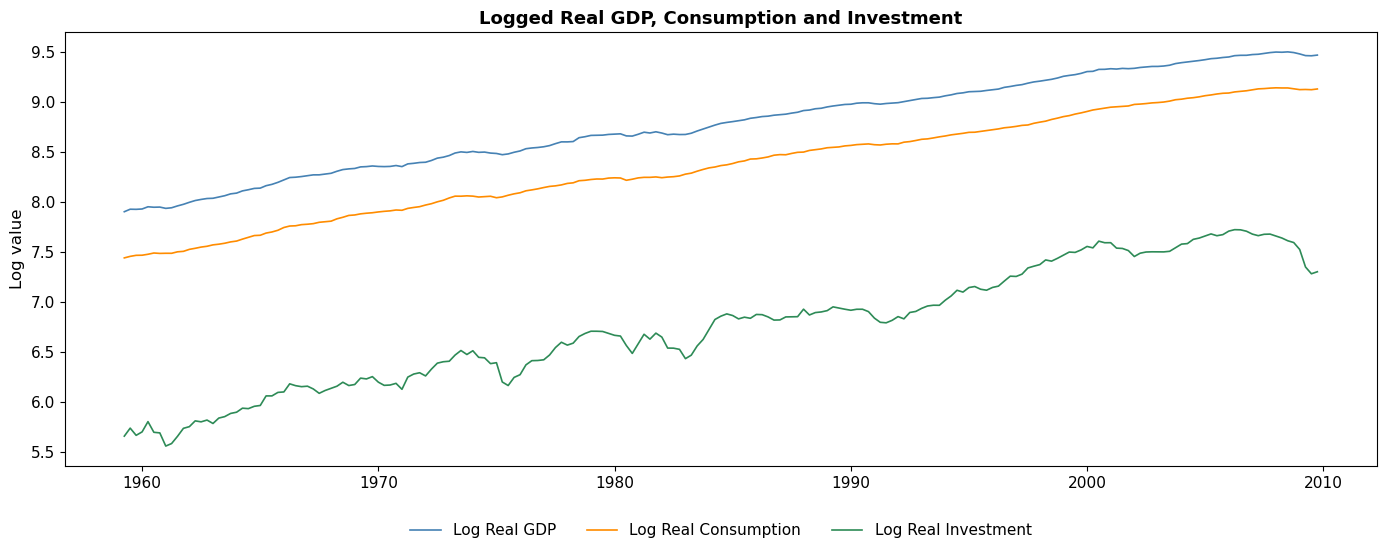

In [4]:
# Time series plot of logged variables
fig, ax = plt.subplots(figsize=(14, 6))
fig.patch.set_alpha(0); ax.patch.set_alpha(0); ax.grid(False)

ax.plot(LGCI['Lrealgdp'], color='steelblue', linewidth=1.2, label='Log Real GDP')
ax.plot(LGCI['Lrealcons'], color='darkorange', linewidth=1.2, label='Log Real Consumption')
ax.plot(LGCI['Lrealinv'], color='seagreen', linewidth=1.2, label='Log Real Investment')
ax.set_title('Logged Real GDP, Consumption and Investment', fontsize=13, fontweight='bold')
ax.set_ylabel('Log value')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=3, frameon=False)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('TplotLGCI_Prob04.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()


## 2. Preliminary OLS Regression


In [5]:
# OLS regression of Lrealgdp on Lrealcons and Lrealinv
Llinearmod = smf.ols('Lrealgdp ~ Lrealcons + Lrealinv', data=LGCI).fit()
print(Llinearmod.summary())


                            OLS Regression Results                            
Dep. Variable:               Lrealgdp   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.588e+05
Date:                Mon, 09 Feb 2026   Prob (F-statistic):          7.81e-321
Time:                        16:26:03   Log-Likelihood:                 615.76
No. Observations:                 203   AIC:                            -1226.
Df Residuals:                     200   BIC:                            -1216.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2210      0.030     40.890      0.0

In [6]:
# KPSS stationarity test on residuals
kpss_result = sm.tsa.kpss(Llinearmod.resid, regression='c', nlags='auto')
print(f'KPSS statistic: {kpss_result[0]:.4f}')
print(f'P-value: {kpss_result[1]:.4f}')
print(f'Critical values: {kpss_result[3]}')
print(f'\nResiduals are stationary? {"YES ✅" if kpss_result[1] >= 0.05 else "NO ❌"}')


KPSS statistic: 0.1341
P-value: 0.1000
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

Residuals are stationary? YES ✅


/var/folders/pk/sxdc5n5x6mb322grbvxz_nm40000gp/T/ipykernel_45996/1853368705.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = sm.tsa.kpss(Llinearmod.resid, regression='c', nlags='auto')


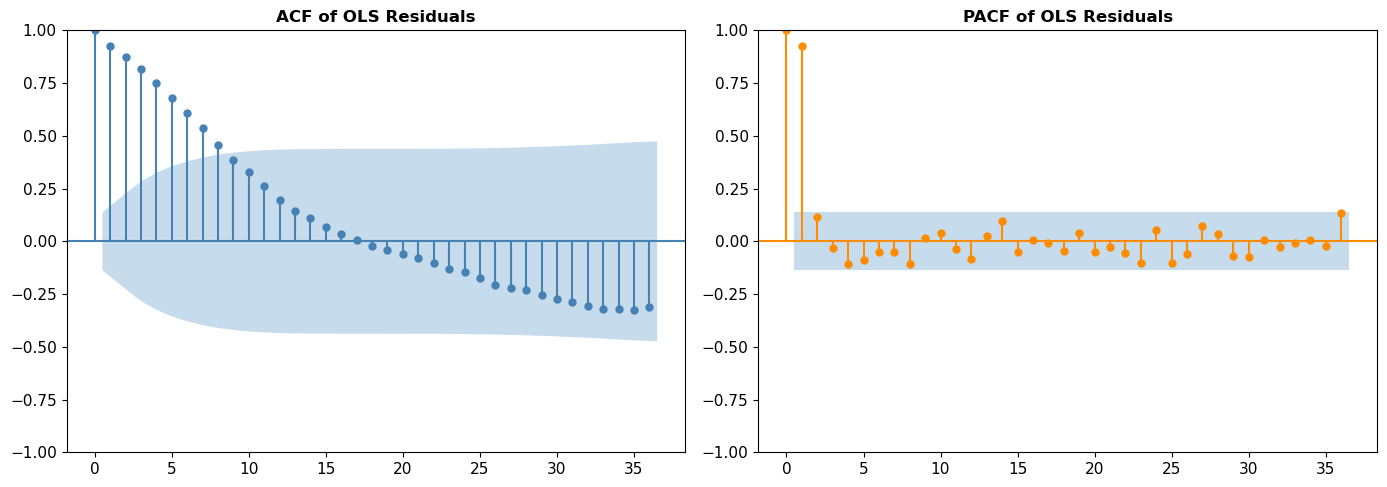

PACF cuts off after lag 1 → use SARIMAX(1,0,0)(0,0,0)_4


In [7]:
# ACF and PACF of OLS residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_alpha(0)
for ax in axes:
    ax.patch.set_alpha(0); ax.grid(False)

plot_acf(Llinearmod.resid, lags=36, ax=axes[0], color='steelblue',
         vlines_kwargs={'colors': 'steelblue'})
axes[0].set_title('ACF of OLS Residuals', fontsize=12, fontweight='bold')

plot_pacf(Llinearmod.resid, lags=36, ax=axes[1], color='darkorange',
          vlines_kwargs={'colors': 'darkorange'})
axes[1].set_title('PACF of OLS Residuals', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('ACF_PACF_OLS_Resid_Prob04.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()
print('PACF cuts off after lag 1 → use SARIMAX(1,0,0)(0,0,0)_4')


## 3. SARIMAX(1,0,0)(0,0,0)$_4$ Model


In [8]:
# Fit SARIMAX model
X = LGCI[['Lrealcons', 'Lrealinv']]
Y = LGCI['Lrealgdp']
X = sm.add_constant(X, prepend=False)

sarimaxmod = SARIMAX(endog=Y, exog=X, order=(1, 0, 0),
                     seasonal_order=(0, 0, 0, 4)).fit(method='bfgs', disp=False)
print(sarimaxmod.summary())


                               SARIMAX Results                                
Dep. Variable:               Lrealgdp   No. Observations:                  203
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 865.721
Date:                Mon, 09 Feb 2026   AIC                          -1721.442
Time:                        16:26:03   BIC                          -1704.876
Sample:                    03-31-1959   HQIC                         -1714.740
                         - 09-30-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Lrealcons      0.7276      0.021     34.691      0.000       0.686       0.769
Lrealinv       0.1265      0.005     27.803      0.000       0.118       0.135
const          1.8391      0.171     10.746      0.0

## 4. Residual Diagnostics


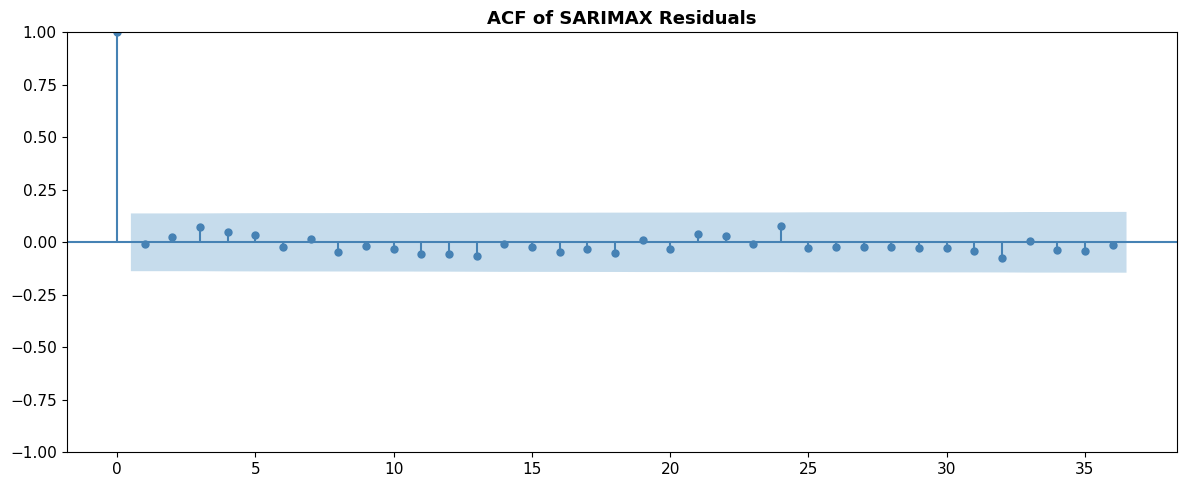

In [9]:
# ACF of SARIMAX residuals
fig, ax = plt.subplots(figsize=(12, 5))
fig.patch.set_alpha(0); ax.patch.set_alpha(0); ax.grid(False)
plot_acf(sarimaxmod.resid, lags=36, ax=ax, color='steelblue',
         vlines_kwargs={'colors': 'steelblue'})
ax.set_title('ACF of SARIMAX Residuals', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('ACF_SARIMAX_Resid_Prob04.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()


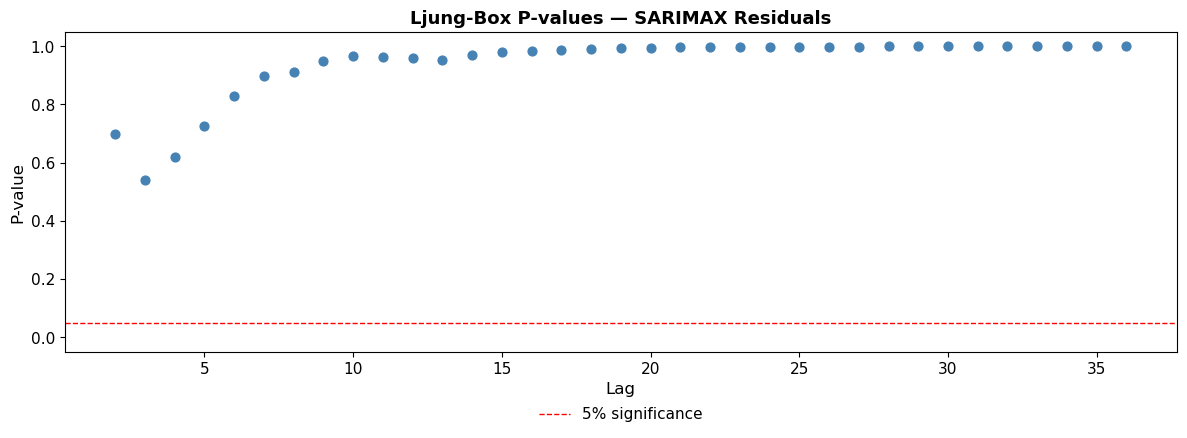

All p-values >> 0.05 → model is adequate ✅


In [10]:
# Ljung-Box test of SARIMAX residuals
fig, ax = plot_ljungbox_pvalues(sarimaxmod.resid, noestimatedcoef=1, nolags=36,
    title='Ljung-Box P-values — SARIMAX Residuals')
plt.savefig('PvSARIMAX_Resid_Prob04.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()
print('All p-values >> 0.05 → model is adequate ✅')


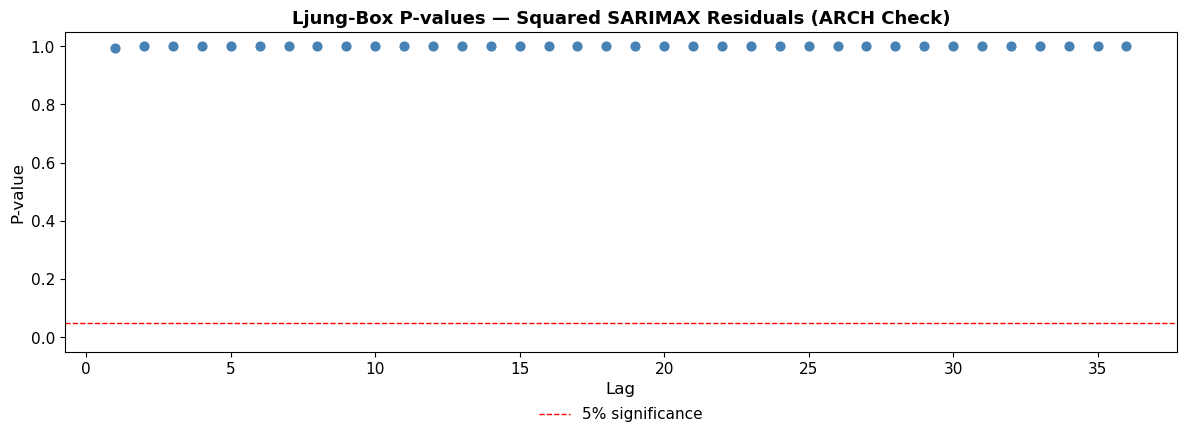

No ARCH effect in the residual series ✅


In [11]:
# Ljung-Box test of squared residuals (ARCH effect)
fig, ax = plot_ljungbox_pvalues(sarimaxmod.resid**2, noestimatedcoef=0, nolags=36,
    title='Ljung-Box P-values — Squared SARIMAX Residuals (ARCH Check)')
plt.savefig('PvSARIMAX_SqResid_Prob04.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()
print('No ARCH effect in the residual series ✅')


## Conclusion

The SARIMAX(1,0,0)(0,0,0)$_4$ model with `Lrealcons` and `Lrealinv` as exogenous regressors is parsimonious and adequate. Residuals resemble white noise (all Ljung-Box p-values > 0.05) and show no ARCH effects.
